In [1]:
# Reddit data analysis task starter.
import html
import json
import string
import re
import nltk
import praw
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

In [2]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [3]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

50

In [4]:
# data record example
data[0]

{'id': 'fu9p78',
 'title': 'Sub Rules and Clarifications - PLEASE READ BEFORE POSTING',
 'text': '**LATEST REVISION 03/01/2022**\n\nWe want to welcome *all* to the ecommerce sub.  In the interest in trying to keep the sub as free of spam / promotional posts as possible, the community has adopted the following rules and posting guidelines.  If you have any issues or questions please click [HERE](https://old.reddit.com/message/compose?to=%2Fr%2Fecommerce) to message the moderators directly.  \n\n**NEW POST OR COMMENT NOT SHOWING UP?**\n\nIn an effort to fight rampant spam that is typical for such a sub, the mods have enacted automated removal of posts with certain criteria.  Currently, the sub **requires a Reddit account age of 48 hours and a minimum Reddit comment karma score of 10**.  There are no exceptions to this, so please do not contact mods for an exception.  You will not be able to post or comment in the sub until you meet the minimum requirement for contributing.  \n\n**ECOMMER

In [5]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,Sub Rules and Clarifications - PLEASE READ BEF...
1,Shopify app idea feedback
2,Please help me with my store!
3,How would you professional stop working with a...
4,Newbie here: What is this Job called?
5,Need Help For Fulfilment Service in Europe🇪🇺
6,What has been your biggest obstacle to being s...
7,Shopify Guidance
8,Should I make a new website for my ecommerce s...
9,How to get verified Amazon reviews from off-Am...


In [6]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts

,title,post_id,text,comments_lev1,comments_lev2
0,Sub Rules and Clarifications - PLEASE READ BEF...,fu9p78,**LATEST REVISION 03/01/2022**\n\nWe want to w...,[removed] [removed] [removed] [removed] [deleted],[removed] [removed]
1,Shopify app idea feedback,wcx6av,Problem:\nBrands are plagued with “Where is my...,It sounds like a good idea. If an owner wanted...,Thanks for your input. Do you run a store?
2,Please help me with my store!,wcxwwq,I am needing some help from some experienced p...,,
3,How would you professional stop working with a...,wcnwak,Been working with a manufacturer over the past...,The best thing to do is give the factory exact...,"Wow, this is one of the best answers to a ques..."
4,Newbie here: What is this Job called?,wcrexg,I heard a guy saying you can make a load of mo...,This is basically the dream that the guy in th...,"No, it's nothing about dropshipping, it's just..."
5,Need Help For Fulfilment Service in Europe🇪🇺,wcurhq,Hi !! Friends \nI need fulfilment service for ...,,
6,What has been your biggest obstacle to being s...,wcyqvc,I world like to know more,Traffic is everyone’s biggest problem,
7,Shopify Guidance,wcydtp,I have been running my shop for a couple of yr...,,
8,Should I make a new website for my ecommerce s...,wcnskk,"Hey people, so I recently started a new job at...",Hmm. Being affiliated to a real physical golf ...,It's locally specific. It's called golfparktha...
9,How to get verified Amazon reviews from off-Am...,wcpztm,We have a successful ecom business that has be...,Don’t waste your time. I’ll explain. Less th...,"Yeah there's the Vine program, but it's only f..."


In [7]:
# text cleaning function: see prior class modules
stop_words = nltk.corpus.stopwords.words('english')
new_stop_words = ['hey','everyone','ive','subreddit','every','day','getting','new','unionizing','peeps',
                  'asking','begin','horror','op','stories','telling','unionize','im','organizer','one',
                  'broad','newer','filed','want','share','broad','strokes','got','whole','idea','seemed',
                  'nebulous','scary','first','board','actually','suprisingly','easy','start','hope',
                  'sharing','experience','make','think','less','intimidating','may','whether','right','post',
                  'isnt','really','conversation','figure','step','reach','seriously','even','thinking',
                  'wanting','theyre','twitter','advice','stage','likely','theres','thats',
                  'already','organizing','put','contact','spoken','four','past','couple','fuck','advice','gon','na','kno','cuz','trenta','rant','sensitive',
                  'documentation','pregnancy','honest','mistake','shit','love','u','time','know','partner','get','much',
                  'someone','need','thing','lol','still','looks','like','union','dues','dress','code','end','keg',
                  'pronoun','pins','mental','health','us','sm','charge','wear','shoes','go','home','never','ball','golf','ass']

stop_words.extend(new_stop_words)

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [8]:
# add clean text column with combined comments of both levels
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,Sub Rules and Clarifications - PLEASE READ BEF...,fu9p78,**LATEST REVISION 03/01/2022**\n\nWe want to w...,[removed] [removed] [removed] [removed] [deleted],[removed] [removed],latest revision welcome ecommerce sub interest...
1,Shopify app idea feedback,wcx6av,Problem:\nBrands are plagued with “Where is my...,It sounds like a good idea. If an owner wanted...,Thanks for your input. Do you run a store?,problem brands plagued order emails means cust...
2,Please help me with my store!,wcxwwq,I am needing some help from some experienced p...,,,needing help experienced people ecommerce foun...
3,How would you professional stop working with a...,wcnwak,Been working with a manufacturer over the past...,The best thing to do is give the factory exact...,"Wow, this is one of the best answers to a ques...",working manufacturer months come conclusion un...
4,Newbie here: What is this Job called?,wcrexg,I heard a guy saying you can make a load of mo...,This is basically the dream that the guy in th...,"No, it's nothing about dropshipping, it's just...",heard guy saying load money clients businesses...
5,Need Help For Fulfilment Service in Europe🇪🇺,wcurhq,Hi !! Friends \nI need fulfilment service for ...,,,hi friends fulfilment service business field p...
6,What has been your biggest obstacle to being s...,wcyqvc,I world like to know more,Traffic is everyone’s biggest problem,,world moretraffic everyones biggest problem
7,Shopify Guidance,wcydtp,I have been running my shop for a couple of yr...,,,running shop yrs l odd random sale figured set...
8,Should I make a new website for my ecommerce s...,wcnskk,"Hey people, so I recently started a new job at...",Hmm. Being affiliated to a real physical golf ...,It's locally specific. It's called golfparktha...,people recently started job club built website...
9,How to get verified Amazon reviews from off-Am...,wcpztm,We have a successful ecom business that has be...,Don’t waste your time. I’ll explain. Less th...,"Yeah there's the Vine program, but it's only f...",successful ecom business running several years...


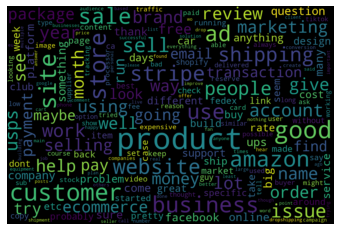

In [9]:
# most common keywords
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
text_combined = ' '.join(df_posts['text_clean'])
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [10]:
# extract keyword counts
# https://stackoverflow.com/questions/60234036/python-word-count-from-wordcloud
kwords = WordCloud().process_text(text_combined)
kwords

{'latest': 2,
 'revision': 1,
 'welcome': 2,
 'ecommerce': 23,
 'sub': 12,
 'interest': 3,
 'trying': 9,
 'keep': 13,
 'free': 14,
 'spam': 3,
 'promotional': 1,
 'posts': 9,
 'possible': 12,
 'community': 1,
 'adopted': 1,
 'following': 1,
 'posting': 4,
 'guidelines': 1,
 'please': 8,
 'click': 4,
 'message': 2,
 'moderators': 1,
 'directly': 4,
 'comment': 9,
 'showing': 6,
 'effort': 6,
 'fight': 1,
 'rampant': 1,
 'typical': 2,
 'mods': 3,
 'enacted': 1,
 'automated': 3,
 'removal': 1,
 'certain': 2,
 'criteria': 1,
 'currently': 7,
 'requires': 1,
 'reddit': 6,
 'account': 25,
 'age': 1,
 'hours': 4,
 'minimum': 5,
 'karma': 1,
 'score': 1,
 'exception': 4,
 'able': 11,
 'meet': 1,
 'requirement': 2,
 'contributing': 1,
 'solicit': 1,
 'way': 25,
 'via': 3,
 'request': 3,
 'dm': 2,
 'referral': 2,
 'others': 9,
 'try': 22,
 'initiate': 1,
 'personal': 5,
 'user': 7,
 'banned': 2,
 'asked': 1,
 'second': 3,
 'help': 27,
 'promote': 3,
 'nft': 4,
 'discussion': 1,
 'selling': 25,
 

In [11]:
# transform that dictionary into a pandas DataFrame
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords

,count
keyword,
latest,2
revision,1
welcome,2
ecommerce,23
sub,12
...,...
brick mortar,3
rei type,3
payment processor,8


In [12]:
# transform that dictionary into a pandas DataFrame
df_kwords2 = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count'])
df_kwords2

,keyword,count
0,latest,2
1,revision,1
2,welcome,2
3,ecommerce,23
4,sub,12
...,...,...
2474,brick mortar,3
2475,rei type,3
2476,payment processor,8
2477,cb ratio,3


In [13]:
df_kwords2[df_kwords2['keyword'].isin(['shopify','amazon','ebay', 
                                       'alibaba','walmart'])]        

,keyword,count
211,shopify,14
682,amazon,40
939,walmart,1
940,ebay,7
1702,alibaba,1


<AxesSubplot:xlabel='keyword'>

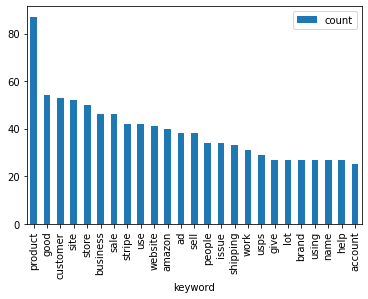

In [14]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(25).plot.bar()

In [15]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [16]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [17]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('ecommerce', 'site'), 3),
 (('removed', 'removed'), 4),
 (('customer', 'support'), 3),
 (('facebook', 'ads'), 3),
 (('quality', 'means'), 3),
 (('give', 'exact'), 3),
 (('take', 'look'), 3),
 (('try', 'sell'), 3),
 (('last', 'year'), 3),
 (('drop', 'shipping'), 3),
 (('run', 'ads'), 7),
 (('could', 'use'), 3),
 (('black', 'diamond'), 3),
 (('big', 'fans'), 3),
 (('saying', 'name'), 3),
 (('brand', 'name'), 4),
 (('ask', 'review'), 3),
 (('amazon', 'reviews'), 4),
 (('user', 'generated'), 5),
 (('generated', 'content'), 5),
 (('social', 'media'), 4),
 (('attribution', 'link'), 3),
 (('good', 'luck'), 3),
 (('product', 'pages'), 3),
 (('years', 'ago'), 4),
 (('full', 'job'), 3),
 (('would', 'use'), 3),
 (('payment', 'processors'), 3),
 (('collect', 'vat'), 3),
 (('high', 'risk'), 3),
 (('phone', 'number'), 5),
 (('personal', 'account'), 5),
 (('live', 'chat'), 3),
 (('drupal', '9'), 3),
 (('free', 'shipping'), 5),
 (('influencer', 'marketing'), 6),
 (('discounted', 'rates'), 4),
 (('1

In [18]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
run ads,7
influencer marketing,6
phone number,5
payment processor,5
120 days,5
personal account,5
free shipping,5
generated content,5
use stripe,5


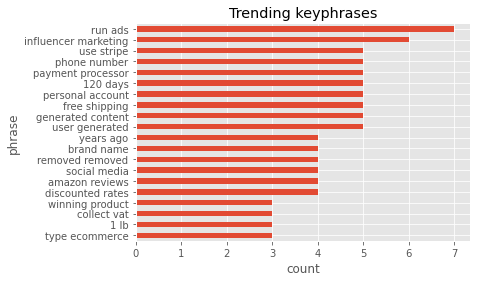

In [19]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()

In [20]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_posts['polarity'] = df_posts['text_clean'].apply(sentim_polarity)
df_posts['subjectivity'] = df_posts['text_clean'].apply(sentim_subject)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
0,Sub Rules and Clarifications - PLEASE READ BEF...,fu9p78,**LATEST REVISION 03/01/2022**\n\nWe want to w...,[removed] [removed] [removed] [removed] [deleted],[removed] [removed],latest revision welcome ecommerce sub interest...,0.194727,0.510608
1,Shopify app idea feedback,wcx6av,Problem:\nBrands are plagued with “Where is my...,It sounds like a good idea. If an owner wanted...,Thanks for your input. Do you run a store?,problem brands plagued order emails means cust...,0.077778,0.407407
2,Please help me with my store!,wcxwwq,I am needing some help from some experienced p...,,,needing help experienced people ecommerce foun...,0.194444,0.416667
3,How would you professional stop working with a...,wcnwak,Been working with a manufacturer over the past...,The best thing to do is give the factory exact...,"Wow, this is one of the best answers to a ques...",working manufacturer months come conclusion un...,0.153241,0.473005
4,Newbie here: What is this Job called?,wcrexg,I heard a guy saying you can make a load of mo...,This is basically the dream that the guy in th...,"No, it's nothing about dropshipping, it's just...",heard guy saying load money clients businesses...,0.108929,0.383844
5,Need Help For Fulfilment Service in Europe🇪🇺,wcurhq,Hi !! Friends \nI need fulfilment service for ...,,,hi friends fulfilment service business field p...,0.000000,0.000000
6,What has been your biggest obstacle to being s...,wcyqvc,I world like to know more,Traffic is everyone’s biggest problem,,world moretraffic everyones biggest problem,0.000000,0.000000
7,Shopify Guidance,wcydtp,I have been running my shop for a couple of yr...,,,running shop yrs l odd random sale figured set...,0.160173,0.557792
8,Should I make a new website for my ecommerce s...,wcnskk,"Hey people, so I recently started a new job at...",Hmm. Being affiliated to a real physical golf ...,It's locally specific. It's called golfparktha...,people recently started job club built website...,0.152434,0.486152
9,How to get verified Amazon reviews from off-Am...,wcpztm,We have a successful ecom business that has be...,Don’t waste your time. I’ll explain. Less th...,"Yeah there's the Vine program, but it's only f...",successful ecom business running several years...,0.200000,0.525914


In [21]:
# define the list of brands to analyze, consistent with the search topi
# for which the tweets were collected
brands = ['shopify','amazon','ebay','alibaba','walmart'] 

In [22]:
df_brands = pd.DataFrame(brands, columns=['brand'])
df_brands

,brand
0,shopify
1,amazon
2,ebay
3,alibaba
4,walmart


In [23]:
def brand_sentiment(b):
    return df_posts[df_posts['text_clean'].str.contains(b)]['polarity'].mean()

In [24]:
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands.sort_values(by='average_sentiment', ascending=False)

,brand,average_sentiment
4,walmart,0.355655
3,alibaba,0.193833
2,ebay,0.170628
1,amazon,0.154601
0,shopify,0.075102


In [25]:
df_posts.sort_values(by='polarity', ascending=False).head(10)

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
20,Shipping revenue with multi vendors?,wc9uim,How do websites like stockX.com and goat.com m...,Customers pay a premium because they want the ...,"Yes, but who pays for both shipments (vendor t...",websites revenue vendor ship product authentic...,0.800000,0.400000
16,What platforms are you using for drop shipping?,wcd986,Been experiencing issues with suppliers but wa...,What issues did you have with your previous su...,"Just the typical Walmart, EBay, &Amazon which ...",experiencing issues suppliers wanted good plat...,0.355655,0.522619
25,"Those of you who use Shopify, how do you deal ...",wc48j4,"Just got an order that was tagged as a ""High r...",Refund all high risk orders. It’s not worth th...,Even if it's on a prepaid card?,order tagged high risk fraud detected guys dea...,0.330000,0.445000
44,What's your opinion on Influencer Marketing fo...,wb3hns,Would you consider using Influencer Marketing ...,It depends on your product. Using micro-influe...,Thank you for your input. How much would it co...,would consider using influencer marketing good...,0.315000,0.525000
39,ecommerce platform costs,wb2tgq,"\nhi I'm an artist, so you can imagine I don't...",Prestashop is free. But you pay for what you g...,Thank you I'll look into this one. I have some...,hi artist imagine abundance products work subj...,0.306061,0.558081
49,.CSV title modifications,was2u1,Doing dropshipping and getting .csv products f...,"To verify your idea, you should first know how...",,dropshipping products suppliers would modify t...,0.300714,0.593413
33,How did you create your website?,wblgld,Have you considered transitioning?\n\n[View Po...,Notepad gang I’m currently looking to transiti...,"notepad++ 😉 using drupal since 2006, drupal 9 ...",considered transitioning view poll gang curren...,0.300000,0.650000
46,A question about resale / recommerce,wb1x6p,Hello to all eco-aware brands out there! :-) A...,I cannot offer much in the way of insight on r...,,hello brands quick question thoughts resell re...,0.294872,0.540385
32,"Have run ads the past 7 days, no conversions: ...",wb6tla,[Rughub](https://rughub.co.uk/)\n\nBeen runnin...,If you think the problem is in your store then...,"Same for me, the site seems to have an issue. ...",rughub running ads week lots page visits yet s...,0.255559,0.591435
36,Would anyone be kind enough to review my new s...,wb342y,in particular i am interested in how my About ...,You need to revise your copy to be more custom...,"That’s a great help, thank you. Very eye openi...",particular interested spiel comes across unsur...,0.227083,0.306250


In [26]:
df_posts.sort_values(by='polarity', ascending=True).head(10)

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
19,Facebook Ads showing on disabled placements?,wc9tr0,"Hey guys,\n\n&#x200B;\n\nI just activated URL ...",,,guys activated url parameters utm facebook ads...,-0.175000,0.387500
17,Private Labeling,wcgljx,When should I trade mark?\nI’m working to get ...,,,trade mark working product line made point tra...,-0.158333,0.212500
38,What international courier would you choose in...,wb7coc,I am preparing to launch my cannabis business ...,DPD is shit and expensive. I spent two months ...,I suspect around 20% of my sales will be to UK...,preparing launch cannabis business cbd plan sh...,-0.140136,0.559456
15,How long did it take you to become successful ...,wcgqkt,"I’m getting pretty discouraged, I’ve been at t...",This is what they don’t tell you about dropshi...,I think a professional marketing team is a bad...,pretty discouraged ab 7 months ill done failed...,-0.041667,0.523810
12,How to sell a product before it's fully developed,wcs77b,So I just started my first business recently a...,,,started business recently products merch using...,-0.028571,0.450000
22,Basic questions about collecting VAT,wc8mwh,I'm thinking about starting a small business a...,"As a foreign company, it is not required to co...",,starting small business selling digital produc...,-0.018333,0.501667
5,Need Help For Fulfilment Service in Europe🇪🇺,wcurhq,Hi !! Friends \nI need fulfilment service for ...,,,hi friends fulfilment service business field p...,0.000000,0.000000
6,What has been your biggest obstacle to being s...,wcyqvc,I world like to know more,Traffic is everyone’s biggest problem,,world moretraffic everyones biggest problem,0.000000,0.000000
27,What's something thing you hate or miss from e...,wbmhxj,"Platforms like shopify, bigcommerce, etc.",[deleted] Something* Being able to customize t...,Could you elaborate more on the variants part?...,platforms shopify bigcommerce etc deleted some...,0.000000,0.875000
10,How much do you spend monthly on your e-commer...,wcuzae,How much are you spending on your site for man...,,,spending site managing properly view poll,0.000000,0.100000


In [27]:
df_posts.sort_values(by='comments_lev1', ascending=False).head(20)

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
35,Amazon FBA question ?,wbg9kq,"Hello,\n\nI'm a very new to this FBA and im l...",✅first open account\n✅trademark\n✅brand regist...,,hello fba learning left however questions matt...,0.193833,0.398250
11,At what point should you start thinking about ...,wcuj55,Currently at the early stages of the business ...,thinking on marketing when work on the project...,,currently early stages business manufacturer w...,0.050000,0.400000
0,Sub Rules and Clarifications - PLEASE READ BEF...,fu9p78,**LATEST REVISION 03/01/2022**\n\nWe want to w...,[removed] [removed] [removed] [removed] [deleted],[removed] [removed],latest revision welcome ecommerce sub interest...,0.194727,0.510608
27,What's something thing you hate or miss from e...,wbmhxj,"Platforms like shopify, bigcommerce, etc.",[deleted] Something* Being able to customize t...,Could you elaborate more on the variants part?...,platforms shopify bigcommerce etc deleted some...,0.000000,0.875000
36,Would anyone be kind enough to review my new s...,wb342y,in particular i am interested in how my About ...,You need to revise your copy to be more custom...,"That’s a great help, thank you. Very eye openi...",particular interested spiel comes across unsur...,0.227083,0.306250
16,What platforms are you using for drop shipping?,wcd986,Been experiencing issues with suppliers but wa...,What issues did you have with your previous su...,"Just the typical Walmart, EBay, &Amazon which ...",experiencing issues suppliers wanted good plat...,0.355655,0.522619
31,USPS has gone to shit. Considering using UPS m...,wb87ae,I've shipped 99% of my packages with USPS for ...,USPS is good most of the time.\nUPS and fedex ...,^ Agree with this. Ground packages usually run...,shipped 99 packages usps 7 years since ups fed...,0.034296,0.467890
6,What has been your biggest obstacle to being s...,wcyqvc,I world like to know more,Traffic is everyone’s biggest problem,,world moretraffic everyones biggest problem,0.000000,0.000000
49,.CSV title modifications,was2u1,Doing dropshipping and getting .csv products f...,"To verify your idea, you should first know how...",,dropshipping products suppliers would modify t...,0.300714,0.593413
15,How long did it take you to become successful ...,wcgqkt,"I’m getting pretty discouraged, I’ve been at t...",This is what they don’t tell you about dropshi...,I think a professional marketing team is a bad...,pretty discouraged ab 7 months ill done failed...,-0.041667,0.523810


In [28]:
# combine all text for a specific brand
def brand_all_text(b):
    # https://stackoverflow.com/a/51871650
    return ' '.join(df_posts[df_posts['text_clean'].str.contains(b)]['text_clean'])

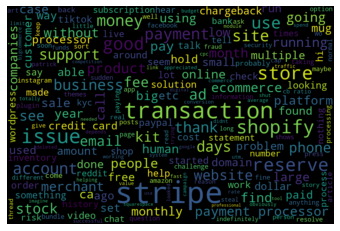

In [29]:
b = 'shopify'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

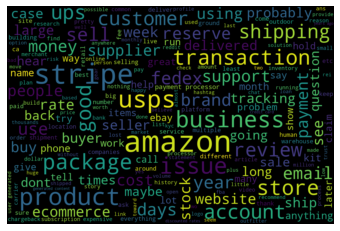

In [30]:
c = 'amazon'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(c))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

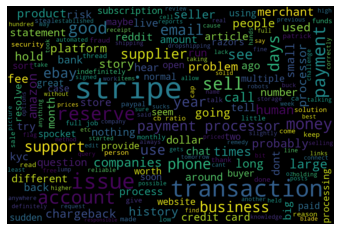

In [31]:
d = 'ebay'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(d))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

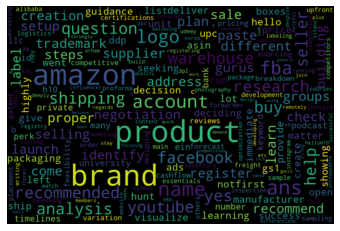

In [32]:
e = 'alibaba'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(e))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

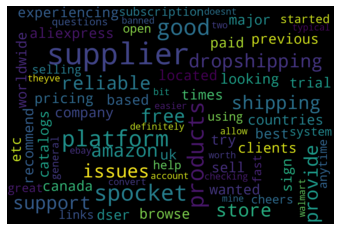

In [33]:
g = 'walmart'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(g))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()